In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
# Load csv into df
df = pd.read_csv(data_interim_dir + 'merged_data.csv',parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Remove basin rig counts
df = df.iloc[:,5:]

# Filter values for only past months
df = df[df.index < this_month]
df = df.reset_index()
df.head()

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2020-09-25,183.0,38.350,41.338,39.780,40.890,39.880,40.1300,40.4360,40.7640,...,29.294485,31.561833,7.099833,63.569511,41.338,44.317847,41.338,52.166664,41.338,96.484511
1,2020-09-18,179.0,37.872,40.570,39.554,40.770,39.556,39.8120,40.1560,40.5500,...,29.153233,31.558139,7.245472,63.411146,40.570,44.210211,40.570,52.322725,40.570,96.532936
2,2020-09-11,180.0,37.322,40.442,37.375,39.450,37.360,37.7275,38.1925,38.6775,...,29.011982,31.554444,7.391111,63.252782,40.442,44.102575,40.442,52.478786,40.442,96.581361
3,2020-09-04,181.0,34.185,39.992,41.842,43.060,41.604,41.9400,42.3080,42.6800,...,28.870730,31.550749,7.536749,63.094417,39.992,43.994939,39.992,52.634846,39.992,96.629786
4,2020-08-28,180.0,33.096,39.220,42.932,45.258,43.074,43.3740,43.6880,44.0000,...,28.811321,31.547123,7.593252,62.988280,39.220,43.811816,39.220,52.536276,39.220,96.348093


In [4]:
df.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,924.648810,70.233785,69.803595,68.946373,76.471579,68.997393,69.342983,69.575608,69.728097,6.716356,...,35.217692,32.292360,2.292361,60.392885,69.803595,46.336355,69.803595,48.906114,69.803595,95.242469
std,391.310448,23.738373,23.882964,24.041636,28.667405,23.978950,23.604010,23.292323,23.019254,1.785249,...,1.867860,0.787002,1.375342,3.715000,23.882964,1.851962,23.882964,3.374268,23.882964,4.352449
min,172.000000,3.324000,3.324000,3.324000,14.236000,3.920000,19.070000,22.670000,24.834000,1.997500,...,27.249729,29.738710,0.798167,54.123720,3.324000,35.169788,3.324000,41.998207,3.324000,81.081620
25%,667.750000,50.342000,49.973000,49.073500,52.209500,49.098500,49.693500,50.236500,50.734500,6.004813,...,34.496668,31.719937,1.646406,57.408588,49.973000,45.863589,49.973000,46.126860,49.973000,91.884984
50%,836.500000,63.785000,62.415000,61.319250,67.411000,61.270000,61.337000,61.315000,61.088000,7.206625,...,35.323721,32.303060,2.033655,60.872948,62.415000,46.575395,62.415000,49.269186,62.415000,95.290334
75%,1355.500000,93.926000,93.926000,93.926000,108.401000,93.948000,93.974000,94.450500,94.598500,7.776938,...,36.515473,32.763135,2.497515,62.516180,93.926000,47.396175,93.926000,51.779580,93.926000,99.145077
max,1609.000000,112.296000,112.296000,112.296000,126.624000,112.808000,113.302000,113.578000,113.692000,9.474250,...,37.737702,33.946000,9.080444,67.705728,112.296000,48.904341,112.296000,54.729117,112.296000,102.590146


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   504 non-null    datetime64[ns]
 1   Total US RigCount      504 non-null    float64       
 2   wti_spot_lag_14        504 non-null    float64       
 3   wti_spot_lag_9         504 non-null    float64       
 4   wti_spot               504 non-null    float64       
 5   brent_spot             504 non-null    float64       
 6   wti_fut_1              504 non-null    float64       
 7   wti_fut_2              504 non-null    float64       
 8   wti_fut_3              504 non-null    float64       
 9   wti_fut_4              504 non-null    float64       
 10  usa_net_import_smooth  504 non-null    float64       
 11  usa_net_import         504 non-null    float64       
 12  usa_stocks_all         504 non-null    float64       
 13  usa_s

Looks good! Let's get started.

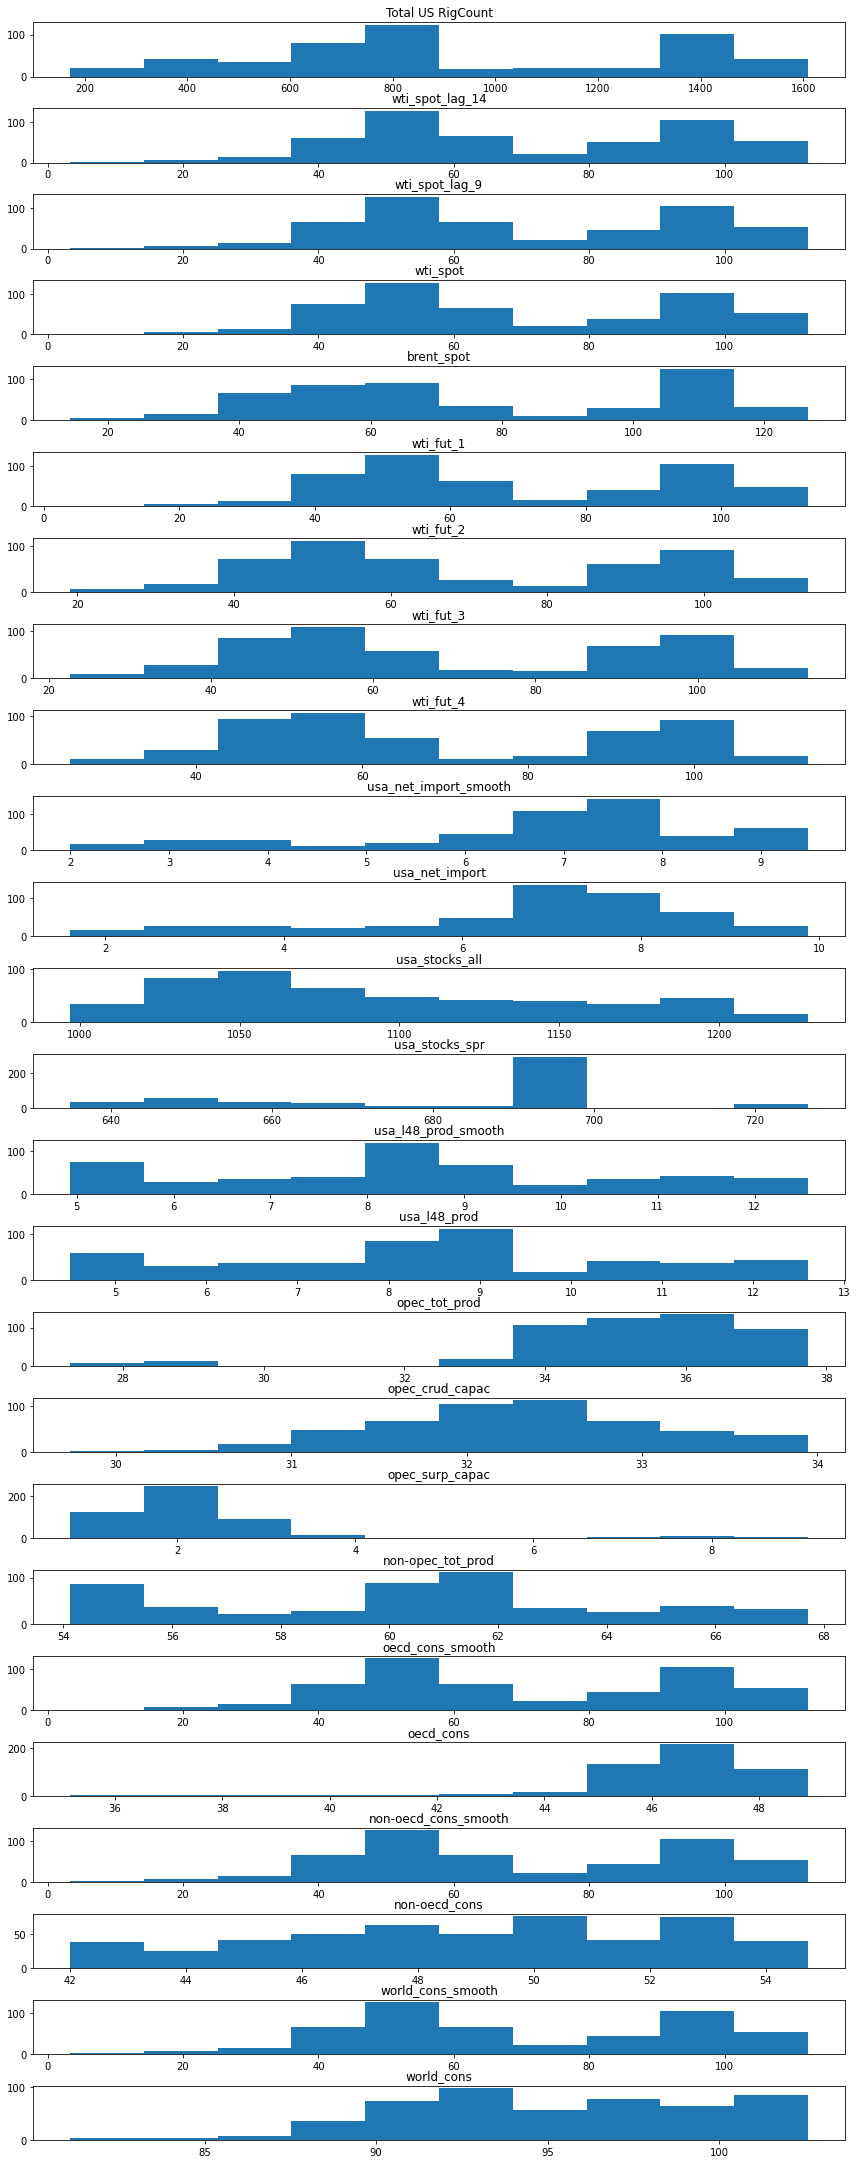

In [6]:
fig, ax = plt.subplots(len(df.columns)-1,figsize=(12,30))
fig.tight_layout()
for i in range(1,len(df.columns)):
    ax[i-1].hist(df.iloc[:,i])
    ax[i-1].set(title=df.columns[i])

Values between the features are very inconsistent and as such should be scaled to minimize any weighting issues with number sizes.

In [7]:
scaler = MinMaxScaler()

df_scaled = df.copy()

for col in df.columns[2:]:
    scaler.fit(df[[col]])
    df_scaled[col] = scaler.transform(df[[col]])
    
df_scaled.describe()

,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,usa_net_import_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,...,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,924.648810,0.614009,0.610061,0.602195,0.553756,0.597654,0.533502,0.515968,0.505234,0.631137,...,0.759724,0.606958,0.180409,0.461579,0.610061,0.813027,0.610061,0.542609,0.610061,0.658383
std,391.310448,0.217839,0.219166,0.220622,0.255075,0.220217,0.250488,0.256219,0.259057,0.238773,...,0.178095,0.187057,0.166058,0.273524,0.219166,0.134840,0.219166,0.265045,0.219166,0.202359
min,172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,667.750000,0.431469,0.428082,0.419828,0.337879,0.414908,0.324980,0.303235,0.291482,0.535970,...,0.690976,0.470903,0.102416,0.241854,0.428082,0.778606,0.428082,0.324302,0.428082,0.502283
50%,836.500000,0.554831,0.542259,0.532203,0.473138,0.526688,0.448542,0.425100,0.407999,0.696710,...,0.769833,0.609502,0.149173,0.496924,0.542259,0.830432,0.542259,0.571128,0.542259,0.660608
75%,1355.500000,0.831425,0.831425,0.831425,0.837856,0.826795,0.794889,0.789595,0.785123,0.772988,...,0.883464,0.718853,0.205179,0.617910,0.831425,0.890192,0.831425,0.768317,0.831425,0.839828
max,1609.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train / Test Split
Define features X, and target variable y

In [107]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame(columns=['feature','vif'])
vif_data['feature'] = X.columns
vif_data['vif'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

vif_data = vif_data.sort_values(by='vif',ascending=False)
vif_data.head(15)

,feature,vif
16,world_cons_smooth,inf
1,wti_spot_lag_9,inf
10,opec_tot_prod,2.338098e+05
11,opec_crud_capac,2.301939e+05
13,non-opec_tot_prod,1.308864e+04
7,usa_stocks_spr,7.258394e+03
8,usa_l48_prod_smooth,6.009079e+03
9,usa_l48_prod,5.462128e+03
6,usa_stocks_all,3.936295e+03
14,oecd_cons,3.734763e+03


In [109]:
X = X.drop(vif_data.feature[vif_data.index[0]],axis=1)
    
vif_data = pd.DataFrame(columns=['feature','vif'])
vif_data['feature'] = X.columns
vif_data['vif'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

vif_data = vif_data.sort_values(by='vif',ascending=False)
vif_data.head(15)

,feature,vif
22,world_cons_smooth,inf
20,non-oecd_cons_smooth,inf
18,oecd_cons_smooth,inf
1,wti_spot_lag_9,inf
6,wti_fut_3,1.140533e+06
5,wti_fut_2,4.688039e+05
7,wti_fut_4,3.242486e+05
14,opec_tot_prod,2.568486e+05
15,opec_crud_capac,2.494165e+05
4,wti_fut_1,8.290111e+04


In [53]:
X_2 = X_1.drop(vif_data[:3].feature,axis=1)
    
vif_data = pd.DataFrame(columns=['feature','vif'])
vif_data['feature'] = X_2.columns
vif_data['vif'] = [variance_inflation_factor(X_2.values,i) for i in range(len(X_2.columns))]

vif_data = vif_data.sort_values(by='vif',ascending=False)
vif_data.head(15)

,feature,vif
10,opec_tot_prod,228841.002967
11,opec_crud_capac,224018.547147
3,wti_fut_1,51389.107223
1,wti_spot,49524.839439
13,non-opec_tot_prod,8527.877115
7,usa_stocks_spr,6172.065518
8,usa_l48_prod_smooth,5639.973731
9,usa_l48_prod,5410.629310
6,usa_stocks_all,2963.542953
12,opec_surp_capac,1453.358928


In [66]:
X_3 = X_2.drop(vif_data.feature[vif_data.index[0]],axis=1)

vif_data = pd.DataFrame(columns=['feature','vif'])
vif_data['feature'] = X_3.columns
vif_data['vif'] = [variance_inflation_factor(X_3.values,i) for i in range(len(X_3.columns))]

vif_data = vif_data.sort_values(by='vif',ascending=False)
vif_data.head(15)

,feature,vif
3,wti_fut_1,49996.037989
1,wti_spot,47911.949810
12,non-opec_tot_prod,7986.180966
7,usa_stocks_spr,6162.621963
8,usa_l48_prod_smooth,5638.319022
9,usa_l48_prod,5402.796689
10,opec_crud_capac,2941.842417
6,usa_stocks_all,2794.657821
4,usa_net_import_smooth,648.651985
2,brent_spot,391.012822


In [34]:
X_4 = X_3.drop(['non-opec_tot_prod'],axis=1)

vif_data = pd.DataFrame(columns=['feature','vif'])
vif_data['feature'] = X_4.columns
vif_data['vif'] = [variance_inflation_factor(X_4.values,i) for i in range(len(X_4.columns))]

vif_data = vif_data.sort_values(by='vif',ascending=False)
vif_data.head(15)

NameError: name 'X_3' is not defined

In [76]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [77]:
calculate_vif_(X)

dropping 'wti_spot_lag_9' at index: 1
dropping 'oecd_cons_smooth' at index: 17
dropping 'oecd_cons' at index: 17
dropping 'non-oecd_cons_smooth' at index: 17
dropping 'wti_fut_3' at index: 5
dropping 'opec_tot_prod' at index: 12
dropping 'wti_fut_1' at index: 3
dropping 'wti_fut_2' at index: 3
dropping 'world_cons' at index: 15
dropping 'non-opec_tot_prod' at index: 12
dropping 'usa_l48_prod_smooth' at index: 8
dropping 'wti_fut_4' at index: 3
dropping 'usa_stocks_spr' at index: 6
dropping 'opec_crud_capac' at index: 7
dropping 'non-oecd_cons' at index: 8
dropping 'usa_stocks_all' at index: 5
dropping 'wti_spot' at index: 1
dropping 'usa_net_import_smooth' at index: 2
dropping 'world_cons_smooth' at index: 5
dropping 'wti_spot_lag_14' at index: 0
dropping 'usa_net_import' at index: 1
dropping 'usa_l48_prod' at index: 1
Remaining variables:
Index(['brent_spot', 'opec_surp_capac'], dtype='object')


,brent_spot,opec_surp_capac
0,40.8900,7.099833
1,40.7700,7.245472
2,39.4500,7.391111
3,43.0600,7.536749
4,45.2580,7.593252
...,...,...
499,114.5260,3.681155
500,110.4925,3.700494
501,102.8060,3.700373
502,99.9040,3.700252


Train / test split will be done using sklearn's TimeSeriesSplit. Will need to be redefined and used in a pipeline in the modelling phase.

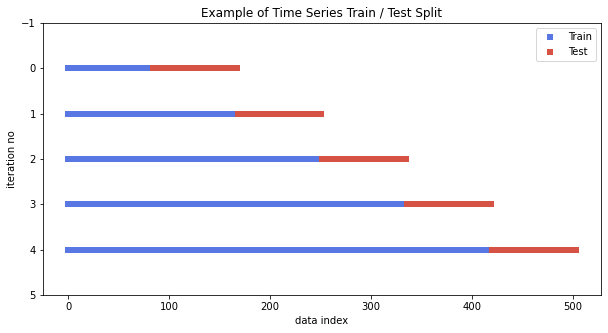

In [9]:
n_splits = 5

ts_cv = TimeSeriesSplit(n_splits = n_splits)

X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

fig, ax = plt.subplots(figsize=(10,5))
for ii, (tr,tt) in enumerate(ts_cv.split(X,y)):
    train = ax.scatter(tr,[ii]*len(tr), c=[plt.cm.coolwarm(.1)],marker='_',lw=6,label='Train')
    test = ax.scatter(tt,[ii]*len(tt), c=[plt.cm.coolwarm(.9)],marker='_',lw=6,label='Test')
    
    ax.set(ylim=[5,-1], title='Example of Time Series Train / Test Split',xlabel='data index',ylabel='iteration no')
    ax.legend([train,test],['Train','Test'])

In [10]:
# Save preprocessed file as CSV
df.to_csv(data_processed_dir+'processed_data.csv',index=False)